In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import time

from tqdm import tqdm
from skimage import measure, morphology
from skimage.draw import polygon
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tempfile import TemporaryFile

# Get a list of patient folders in the data folder.
INPUT_FOLDER = 'example_dcm/'
patients = os.walk('./example_dcm').next()[1]
patients.sort()

ImportError: No module named tqdm

In [22]:
# Load the CT and RT documents for a patient.
def load_scan(path):
    def listdir_nohidden(path):
        for f in os.listdir(path):
            if not f.startswith('.'):
                yield f
    slice_rt = [dicom.read_file(path + "/RTst/" + s) for s in listdir_nohidden(path + "/RTst")]
    slice_ct = [dicom.read_file(path + "/CT/" + s) for s in listdir_nohidden(path + "/CT")]
    slice_ct.sort(key = lambda x: int(x.ImagePositionPatient[2]))    
    return slice_ct, slice_rt

In [23]:
# Convert the pixel values to Hounsfield Units.
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [24]:
def load_all_slices(patientName):
    first_patient_ct, first_patient_rt = load_scan(INPUT_FOLDER + patientName)

    # Make a dictionary mapping the UID values of each slice to the slice number.
    uid_location_dict = {}
    for i, patient_slice in enumerate(first_patient_ct):
        uid_location_dict[patient_slice[0x0008, 0x0018].value] = i

    # Construct a list of regions in the whole scan and their points
    labeled_regions = {};

    cancer_roi_number = -1;

    # Structure Set ROI Sequence is 3006.0020 in the RTst.
    # http://dicom.nema.org/medical/Dicom/2016b/output/chtml/part03/sect_C.8.8.5.html
    for i, ss_roi_sequence_i in enumerate(first_patient_rt[0][0x3006, 0x0020].value):
        if ss_roi_sequence_i[0x3006, 0x0026].value.lower().find('gtv') != 1:
            cancer_roi_number = i;
            
    if cancer_roi_number == -1:
        print "Could not find radiomics_gtv in patient", patientName

    # ROI Contour Sequence is 3006.0039 in the Rtst
    # http://dicom.nema.org/medical/dicom/2016c/output/chtml/part03/sect_C.8.8.6.html
    for i, roi_sequence_i in enumerate(first_patient_rt[0][0x3006, 0x0039].value):
        roi_number = i;
        labeled_regions[roi_number] = { "slices": [] };
        roi_color = roi_sequence_i[0x3006, 0x002A].value;
        contour_sequence = roi_sequence_i[0x3006, 0x0040].value;
        labeled_regions[roi_number]["color"] = roi_color;
        for i, roi_contour_sequence_i in enumerate(contour_sequence):
            # Get the slice number corresponding to roi contour's Referenced SOP Instance UID
            sop_instance_uid = (roi_contour_sequence_i[0x3006,0x0016]).value[0][0x0008,0x1155].value;
            slice_number = uid_location_dict[sop_instance_uid];
            numPoints = roi_contour_sequence_i[0x3006, 0x0046].value;
            contour_type = roi_contour_sequence_i[0x3006, 0x0042].value;
            if contour_type != "CLOSED_PLANAR":
                print("Unsupported contour type found of type ", contour_type);
                exit();
            points = np.array(roi_contour_sequence_i[0x3006, 0x0050].value);
            points.shape = (numPoints, 3);
            zipped = zip(*points);
            zipped[0] = np.subtract(zipped[0], first_patient_ct[slice_number].ImagePositionPatient[0])
            zipped[0] = np.divide(zipped[0], first_patient_ct[slice_number].PixelSpacing[0])
            zipped[1] = np.subtract(zipped[1], first_patient_ct[slice_number].ImagePositionPatient[1])
            zipped[1] = np.divide(zipped[1], first_patient_ct[slice_number].PixelSpacing[1])
            zipped[2] = np.subtract(zipped[2], first_patient_ct[0].ImagePositionPatient[2])
            labeled_regions[roi_number]["slices"].append({
                "sliceNum": slice_number,
                "z": zipped[2][0],
                "data": zipped
            });

    labeled_regions[cancer_roi_number]["slices"] = sorted(labeled_regions[cancer_roi_number]["slices"], key=lambda item: item["z"])

    first_patient_pixels = get_pixels_hu(first_patient_ct)
    
    return first_patient_ct, first_patient_pixels, labeled_regions, cancer_roi_number

('Found ROI: ', 'body')
('Found ROI: ', 'Esophagus')
('Found ROI: ', 'lung')
('Found ROI: ', 'radiomics_gtv')


In [25]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel to mm ratio
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)
    # Get shape in mm
    new_real_shape = image.shape * spacing
    # Round to nearest integer
    new_shape = np.round(new_real_shape)
    # Get pixel to mm ratio after rounding
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    # Zoom the 3d scan as necessary    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    return image, new_spacing

In [26]:
def save_test_and_output(image, labeled_regions, patientName):
    p = image.transpose(2,1,0)
    
    ground_truth = np.zeros(p.shape);
    
    cancer_region = labeled_regions[cancer_roi_number];
    
    for i, region_slice in enumerate(cancer_region["slices"]):
        xx, yy = polygon((region_slice["data"][0]).astype(int), (region_slice["data"][1]).astype(int), (p.shape[0], p.shape[1]));
        xx = xx.astype(int);
        yy = yy.astype(int);
        zz = np.full((len(xx)),(region_slice["data"][2][0])).astype(int)
        ground_truth[xx, yy, zz] = 1;
        if i < len(cancer_region["slices"]) - 1:
                diff = (cancer_region["slices"][i + 1]["z"] - region_slice["z"]);
                if diff > 0:
                    for dz in range(int(region_slice["z"]), int(cancer_region["slices"][i + 1]["z"])):
                        zz = np.full((len(xx)),dz).astype(int)
                        zz == zz.astype(int)
                        ground_truth[xx, yy, zz] = 1;
    
    np.save(INPUT_FOLDER + patientName + "/image", p);
    np.save(INPUT_FOLDER + patientName + "/truth", ground_truth);

In [27]:
for i in tqdm(range(len(patients))):
    if os.path.isfile(INPUT_FOLDER + patients[i] + "/image"):
        if os.path.exists(INPUT_FOLDER + patients[i] + "/truth"):
            print "Skipping patient ", patients[i]
            continue;
    patient_ct, patient_pixels, labeled_regions, cancer_roi_number = load_all_slices(patients[i])
    pix_resampled, spacing = resample(patient_pixels, patient_ct, [1,1,1])
    save_test_and_output(pix_resampled, labeled_regions, patients[i])

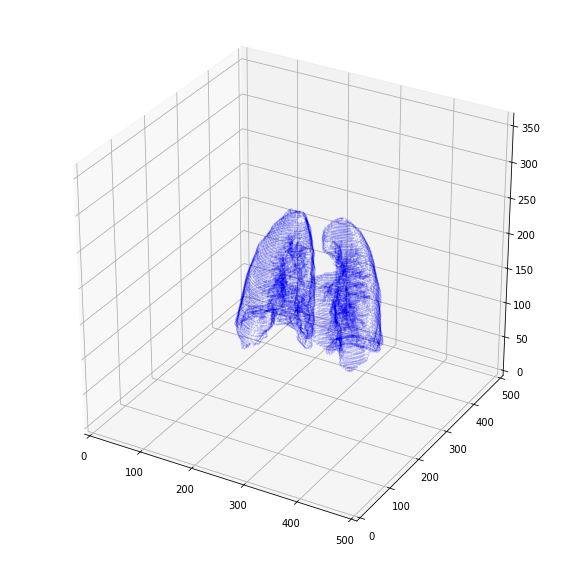